In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from scipy import integrate, stats
import scipy
import time
import warnings
import copy
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from numpy import random
import random as rnd
import math
from tqdm import tqdm 
import tabulate
from numba import njit, jit
from sympy import Interval
from matplotlib.lines import Line2D
import scipy.stats as st
import enum 
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [31]:
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
# Black-Scholes option prices
def blackschol(S0, K, sigma, r, T, optiontype='put', barrier=False, H=-1):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    d1 = (1 / (sigma * np.sqrt(T)))*( np.log(S0/K) + (r + (sigma**2/2))*(T))
    d2 = (1 / (sigma * np.sqrt(T)))*( np.log(S0/K) + (r - (sigma**2/2))*(T))
    c = norm.cdf(d1)* S0 - norm.cdf(d2)* K * np.exp(-r *(T))
    p = norm.cdf(-1*d2) * K * np.exp(-r *(T))  - norm.cdf(-1*d1)* S0 
    
    if barrier:
        assert H!=-1 , 'Enter a Barrier price'
        assert not H>=S0, 'Enter a Barrier less than S0'
        lamda = (r+(sigma**2/2))/sigma**2
        x1 = (np.log(S0/H)/(sigma*np.sqrt(T))) + lamda*sigma*np.sqrt(T)
        y = (np.log(H**2/(S0*K))/(sigma*np.sqrt(T))) + lamda*sigma*np.sqrt(T)
        y1 = (np.log(H/S0)/(sigma*np.sqrt(T))) + lamda*sigma*np.sqrt(T)
        p_di = -S0*norm.cdf(-x1) + K*np.exp(-r*T)*norm.cdf(-x1+sigma*np.sqrt(T)) + S0*(H/S0)**(2*lamda)*(norm.cdf(y)-norm.cdf(y1)) -K*np.exp(-r*T)*(H/S0)**(2*lamda-2)*(norm.cdf(y-sigma*np.sqrt(T))-norm.cdf(y1-sigma*np.sqrt(T)))
        c_di = S0*(H/S0)**(2*lamda)*norm.cdf(y) - K*np.exp(-r*T)*(H/S0)**(2*lamda-2)*norm.cdf(y-sigma*np.sqrt(T))
        c_do = S0*norm.cdf(x1) - K*np.exp(-r*T)*norm.cdf(x1-sigma*np.sqrt(T)) - S0*(H/S0)**(2*lamda)*norm.cdf(y1) + K*np.exp(-r*T)*(H/S0)**(2*lamda-2)*norm.cdf(y1-sigma*np.sqrt(T))
        
        if optiontype=='put':
            if H >= K:
                return 0
            else:
                return p - p_di 
        else:
            if H <= K:
                return c - c_di
            else:
                return c_do
            
    else:
        if optiontype == 'call':
            return c 
        else:
            return p 

def GeneratePathsGBMEuler(NoOfPaths,NoOfSteps,T,r,sigma,S_0):    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
   
    # Euler Approximation
    S1 = np.zeros([NoOfPaths, NoOfSteps+1])
    S1[:,0] =S_0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        
        S1[:,i+1] = S1[:,i] + r * S1[:,i]* dt + sigma * S1[:,i] * (W[:,i+1] - W[:,i])
        time[i+1] = time[i] +dt
        
    # Retun S1 and S2
    paths = {"time":time,"S":S1}
    return paths


def GeneratePathsGBMMilstein(NoOfPaths,NoOfSteps,T,r,sigma,S_0):    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
   
    # Milstein Approximation
    S1 = np.zeros([NoOfPaths, NoOfSteps+1])
    S1[:,0] =S_0
       
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        
        S1[:,i+1] = S1[:,i] + r * S1[:,i]* dt + sigma * S1[:,i] * (W[:,i+1] - W[:,i]) + 0.5 * sigma **2.0 * S1[:,i] * (np.power((W[:,i+1] - W[:,i]),2) - dt)
        time[i+1] = time[i] +dt
        
    # Retun S1 and S2
    paths = {"time":time,"S":S1}
    return paths

def EUOptionPriceFromMCPaths(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    if CP == OptionType.CALL:
        return np.exp(-r*T)*np.mean(np.maximum(S-K,0.0)), stats.sem(np.exp(-r*T)*np.maximum(S-K,0.0))
    elif CP == OptionType.PUT:
        return np.exp(-r*T)*np.mean(np.maximum(K-S,0.0)), stats.sem(np.exp(-r*T)*np.maximum(K-S,0.0))

def BarrierOptionPriceFromMCPaths(CP,S,K,T,r,H):
    # condition for DO option
    indicator = 1*(S.min(axis=1) > H) 
    # S is an array prices with no. of Monte Carlo paths as rows and time points as columns 
    if CP == OptionType.CALL: 
        return np.exp(-r*T)*np.mean(np.maximum(S[:,-1]-K,0.0)*indicator), stats.sem(np.exp(-r*T)*np.maximum(S[:,-1]-K,0.0)*indicator)
    elif CP == OptionType.PUT:
        return np.exp(-r*T)*np.mean(np.maximum(K-S[:,-1],0.0)*indicator), stats.sem(np.exp(-r*T)*np.maximum(K-S[:,-1],0.0)*indicator)
    

def mainCalculation(optiontype,steps, interest, vola , strike ,barrier, maturity = 1, paths=20000, seed=1):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    if optiontype == 'put':
        CP= OptionType.PUT
    else:
        CP= OptionType.CALL
    T = maturity
    r = interest
    sigma = vola
    S0 = 100
    K = strike
    H = barrier
    NoOfSteps =steps
    
    # Simulated paths
    NoOfPathsTemp = paths
    
    # option price
    exactPrice = blackschol(S0, K, sigma, r, T, 'put')
    exactBarrierPrice = blackschol(S0, K,sigma,r,T,'put',True,H)

    np.random.seed(seed)
    PathsEuler    = GeneratePathsGBMEuler(NoOfPathsTemp,NoOfSteps,T,r,sigma,S0)
    np.random.seed(seed)
    PathsMilstein = GeneratePathsGBMMilstein(NoOfPathsTemp,NoOfSteps,T,r,sigma,S0)
    S_Euler = PathsEuler["S"]
    S_Milstein = PathsMilstein["S"]
    priceEuler, seEuler = EUOptionPriceFromMCPaths(CP,S_Euler[:,-1],K,T,r)
    priceMilstein, seMil = EUOptionPriceFromMCPaths(CP,S_Milstein[:,-1],K,T,r)
    barrierpriceEuler, seBarEuler = BarrierOptionPriceFromMCPaths(CP,S_Euler,K,T,r,H)
    barrierpriceMilstein, seBarMil = BarrierOptionPriceFromMCPaths(CP,S_Milstein,K,T,r,H)
        
    return (abs(priceEuler-exactPrice), abs(priceMilstein-exactPrice), abs(barrierpriceEuler-exactBarrierPrice),
            abs(barrierpriceMilstein-exactBarrierPrice), seEuler, seMil, seBarEuler, seBarMil)

In [50]:
path_grid = np.linspace(5e3,5e5,53,dtype=int)

seEuler, seMil, seBarEuler, seBarMil = [], [], [], [] 

for i in tqdm(path_grid):
    tempEuler, tempMil, tempBarEuler, tempBarMil = [], [], [], []
    for j in range(10):
        #mainCalculation(optiontype,steps, interest, vola , strike ,barrier, maturity = 1, paths=20000, seed=1)
        res = mainCalculation(optiontype='put',steps=52,interest=0.0015,vola=0.2,strike=100,barrier=80,
                              maturity=1, paths=i, seed=np.random.randint(1,100)) #using weekly steps
        tempEuler.append(res[4])
        tempMil.append(res[5])
        tempBarEuler.append(res[6])
        tempBarMil.append(res[7])
        
    seEuler.append(np.mean(tempEuler))
    seMil.append(np.mean(tempMil))
    seBarEuler.append(np.mean(tempBarEuler))
    seBarMil.append(np.mean(tempBarMil))

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [46:57<00:00, 53.16s/it]


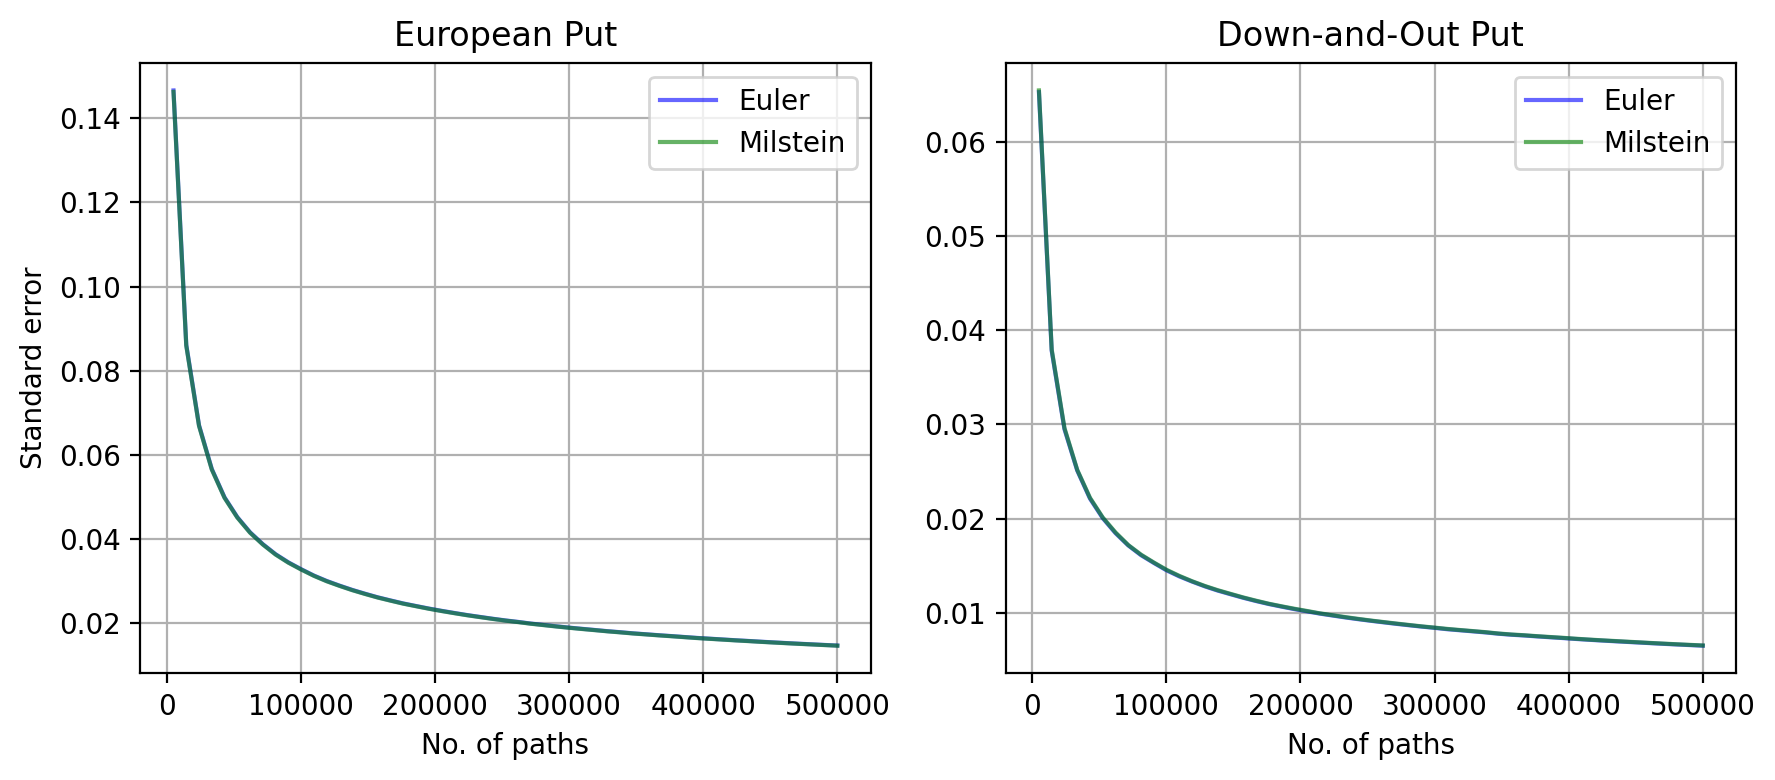

In [55]:
fig = plt.figure(figsize=(9,4),dpi=200)
plt.subplot(121)
plt.plot(path_grid, seEuler, 'b-',alpha=0.6, label="Euler")
plt.plot(path_grid, seMil, 'g-',alpha=0.6, label="Milstein")
plt.xlabel("No. of paths")
plt.ylabel('Standard error')
#plt.yscale('log')
plt.title('European Put')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(path_grid, seBarEuler, 'b-',alpha=0.6, label="Euler")
plt.plot(path_grid, seBarMil, 'g-',alpha=0.6, label="Milstein")
plt.xlabel("No. of paths")
#plt.ylabel('Standard error')
#plt.yscale('log')
plt.title('Down-and-Out Put')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### From the above plots, we see that the standard error is quite low for 200,000 paths for both european and barrier options.  We use 200,000 paths for the following experiments under Black-Scholes.

In [61]:
step_grid = [365,52,12,4]
err_eu, err_mil , errBar_eu, errBar_mil = [], [], [], [] 
for i in tqdm(step_grid):
  
    temp_eu, temp_mil, tempBar_eu, tempBar_mil = [], [], [], []
    for j in range(10):
        res = mainCalculation(optiontype='put',steps=i,interest=0.02,vola=0.2,strike=100,barrier=80, 
                              maturity=1, paths=200000, seed=np.random.randint(1,100)) 
        #res = mainCalculation(steps=i, maturity=1, seed=np.random.randint(1,100),paths=100000)
        temp_eu.append(res[0])
        temp_mil.append(res[1])
        tempBar_eu.append(res[2])
        tempBar_mil.append(res[3])
        
    err_eu.append(np.mean(temp_eu))
    err_mil.append(np.mean(temp_mil)) 
    errBar_eu.append(np.mean(tempBar_eu))
    errBar_mil.append(np.mean(tempBar_mil))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:33<00:00, 98.26s/it]


## Sequential vary the parameteres for Black Scholes

In [224]:
def plotterBS(vary_interest=True, vary_vola=False, vary_bar=False):
    step_grid = [365,52,12,4]
    if vary_interest:
        intrest_grid = np.linspace(0.0015, 0.05, 7)
        for r in intrest_grid:
            err_eu, err_mil , errBar_eu, errBar_mil = [], [], [], [] 
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil = [], [], [], []
                for j in range(10):
                    res = mainCalculation(optiontype='put',steps=i,interest=r,vola=0.2,strike=100,barrier=80, 
                                          maturity=1, paths=200000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
        
            fig, axs = plt.subplots(nrows=1,ncols=2,dpi=150, figsize=(7,3))
            axs[0].plot(1/np.array(step_grid), err_eu, 'rx-',alpha=0.5)
            axs[0].plot(1/np.array(step_grid), err_mil, 'r^-',alpha=0.5)
            axs[0].set_xlabel("$\Delta t$")
            axs[0].set_ylabel('',color='red')
            axs[0].tick_params(axis='y', labelcolor='red')
            axs[0].set_title('European')

            ax1 = axs[0].twinx() 
            ax1.plot(1/np.array(step_grid), np.array(err_eu) - np.array(err_mil), 'bo-',alpha=0.6)
            ax1.set_xlabel("$\Delta t$")
            ax1.set_ylabel('',color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            axs[1].plot(1/np.array(step_grid), errBar_eu, 'rx-', alpha=0.5, label="Euler error")
            axs[1].plot(1/np.array(step_grid), errBar_mil, 'r^-', alpha=0.5, label="Milstein error")
            axs[1].set_xlabel("$\Delta t$")
            axs[1].set_ylabel('',color='red')
            axs[1].tick_params(axis='y', labelcolor='red')
            axs[1].legend(fontsize='x-small')
            axs[1].set_title('Barrier')

            ax2 = axs[1].twinx() 
            ax2.plot(1/np.array(step_grid), np.array(errBar_eu) - np.array(errBar_mil), 'bo-',alpha=0.6,
                     label="Correction"+"\n"+"(Euler$-$Mil)")
            ax2.set_xlabel("$\Delta t$")
            ax2.set_ylabel('',color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.legend(fontsize='x-small',bbox_to_anchor=(1.1, 0.2))
            axs[1].legend(fontsize='x-small',bbox_to_anchor=(1.1, 1.1))

            fig.suptitle('Interest rate {:.2f}%'.format(100*r))
            plt.tight_layout()
            plt.show()
            
    if vary_vola:
        vola_grid = np.linspace(0.1, 0.5, 9)
        for v in vola_grid:
            err_eu, err_mil , errBar_eu, errBar_mil = [], [], [], [] 
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil = [], [], [], []
                for j in range(10):
                    res = mainCalculation(optiontype='put',steps=i,interest=0.01,vola=v,strike=100,barrier=80, 
                                          maturity=1, paths=200000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
        
            fig, axs = plt.subplots(nrows=1,ncols=2,dpi=150, figsize=(7,3))
            axs[0].plot(1/np.array(step_grid), err_eu, 'rx-',alpha=0.5)
            axs[0].plot(1/np.array(step_grid), err_mil, 'r^-',alpha=0.5)
            axs[0].set_xlabel("$\Delta t$")
            axs[0].set_ylabel('',color='red')
            axs[0].tick_params(axis='y', labelcolor='red')
            axs[0].set_title('European')


            ax1 = axs[0].twinx() 
            ax1.plot(1/np.array(step_grid), np.array(err_eu) - np.array(err_mil), 'bo-',alpha=0.6)
            ax1.set_xlabel("$\Delta t$")
            ax1.set_ylabel('',color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            axs[1].plot(1/np.array(step_grid), errBar_eu, 'rx-', alpha=0.5, label="Euler error")
            axs[1].plot(1/np.array(step_grid), errBar_mil, 'r^-', alpha=0.5, label="Milstein error")
            axs[1].set_xlabel("$\Delta t$")
            axs[1].set_ylabel('',color='red')
            axs[1].tick_params(axis='y', labelcolor='red')
            axs[1].legend(fontsize='x-small')
            axs[1].set_title('Barrier')

            ax2 = axs[1].twinx() 
            ax2.plot(1/np.array(step_grid), np.array(errBar_eu) - np.array(errBar_mil), 'bo-',alpha=0.6,
                     label="Correction"+"\n"+"(Euler$-$Mil)")
            ax2.set_xlabel("$\Delta t$")
            ax2.set_ylabel('',color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.legend(fontsize='x-small',bbox_to_anchor=(1.1, 0.2))
            axs[1].legend(fontsize='x-small',bbox_to_anchor=(1.1, 1.1))

            fig.suptitle('Volatility={:.2f}%'.format(100*v))
            plt.tight_layout()
            plt.show()        
            
    if vary_bar:
        bar_grid = np.linspace(80, 99, 9, dtype=int)
        for h in bar_grid:
            err_eu, err_mil , errBar_eu, errBar_mil = [], [], [], [] 
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil = [], [], [], []
                for j in range(10):
                    res = mainCalculation(optiontype='put',steps=i,interest=0.01,vola=0.35,strike=100,barrier=h, 
                                          maturity=1, paths=200000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
        
            fig, axs = plt.subplots(nrows=1,ncols=2,dpi=150, figsize=(7,3))
            axs[0].plot(1/np.array(step_grid), err_eu, 'rx-',alpha=0.5)
            axs[0].plot(1/np.array(step_grid), err_mil, 'r^-',alpha=0.5)
            axs[0].set_xlabel("$\Delta t$")
            axs[0].set_ylabel('',color='red')
            axs[0].tick_params(axis='y', labelcolor='red')
            axs[0].set_title('European')

            ax1 = axs[0].twinx() 
            ax1.plot(1/np.array(step_grid), np.array(err_eu) - np.array(err_mil), 'bo-',alpha=0.6)
            ax1.set_xlabel("$\Delta t$")
            ax1.set_ylabel('',color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            axs[1].plot(1/np.array(step_grid), errBar_eu, 'rx-', alpha=0.5, label="Euler error")
            axs[1].plot(1/np.array(step_grid), errBar_mil, 'r^-', alpha=0.5, label="Milstein error")
            axs[1].set_xlabel("$\Delta t$")
            axs[1].set_ylabel('',color='red')
            axs[1].tick_params(axis='y', labelcolor='red')
            axs[1].legend(fontsize='x-small')
            axs[1].set_title('Barrier')

            ax2 = axs[1].twinx() 
            ax2.plot(1/np.array(step_grid), np.array(errBar_eu) - np.array(errBar_mil), 'bo-',alpha=0.6,
                     label="Correction"+"\n"+"(Euler$-$Mil)")
            ax2.set_xlabel("$\Delta t$")
            ax2.set_ylabel('',color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.legend(fontsize='x-small',bbox_to_anchor=(1.1, 0.2))
            axs[1].legend(fontsize='x-small',bbox_to_anchor=(1.1, 1.1))

            fig.suptitle('Barrier={}'.format(h))
            plt.tight_layout()
            plt.show()             

### Vary interest. Fix barrier = $80$, volatility = $20\%$

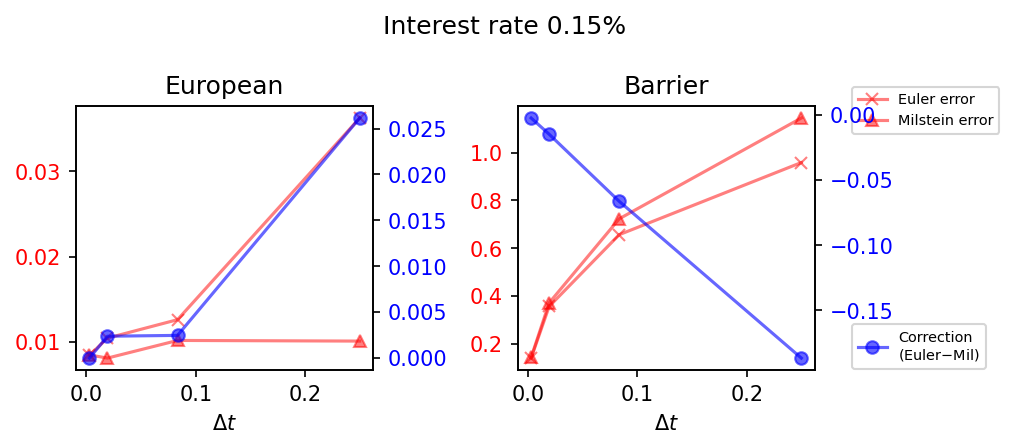

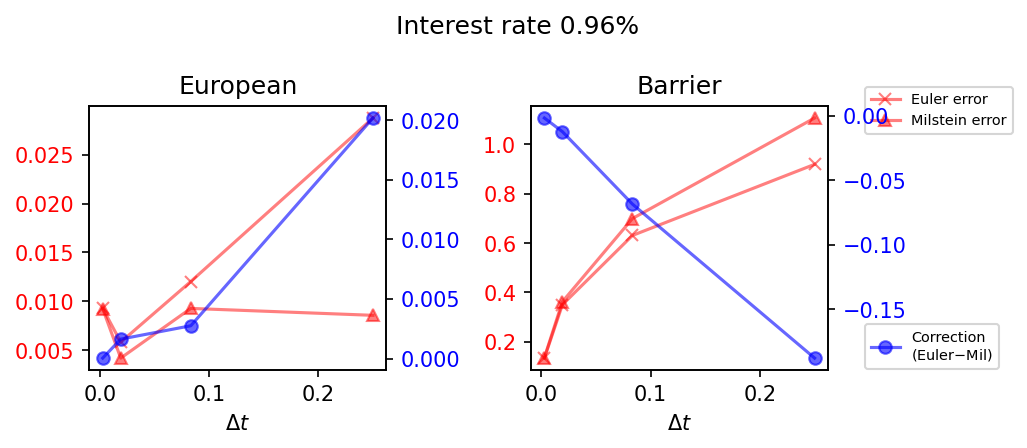

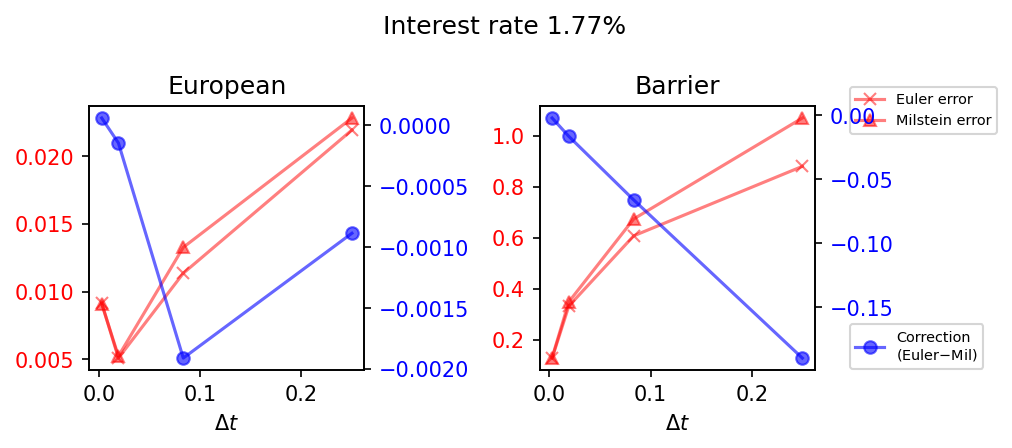

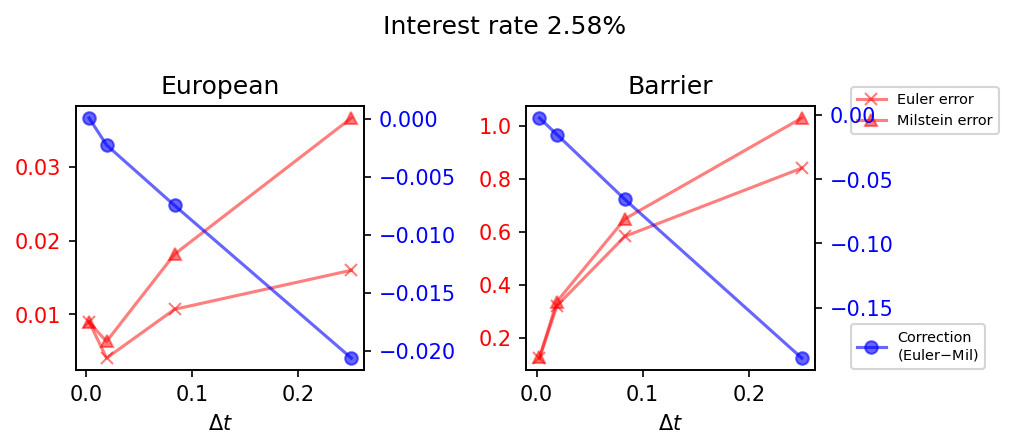

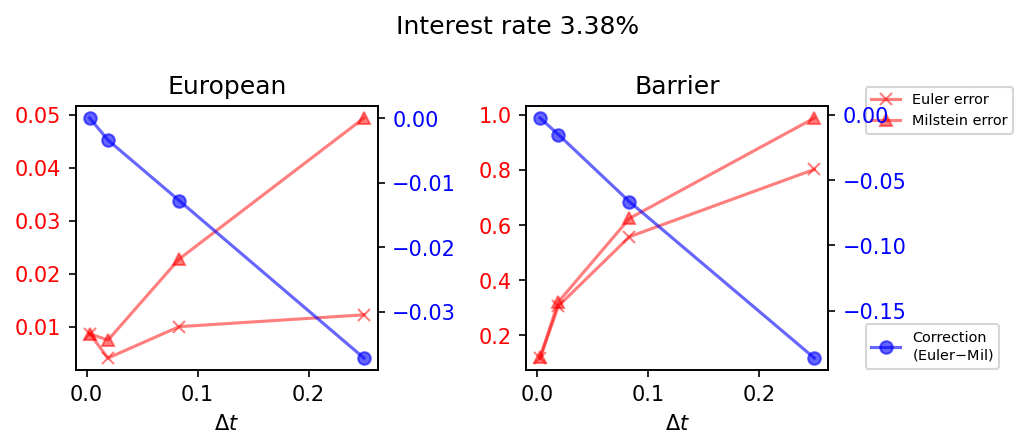

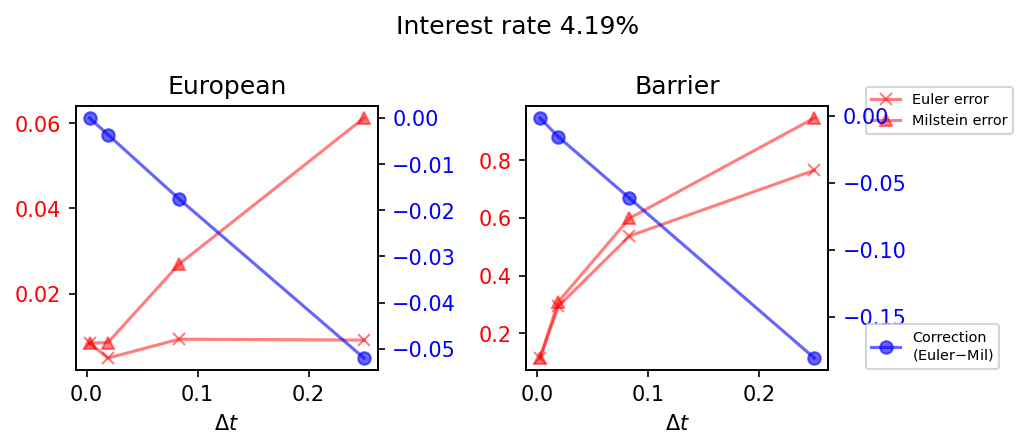

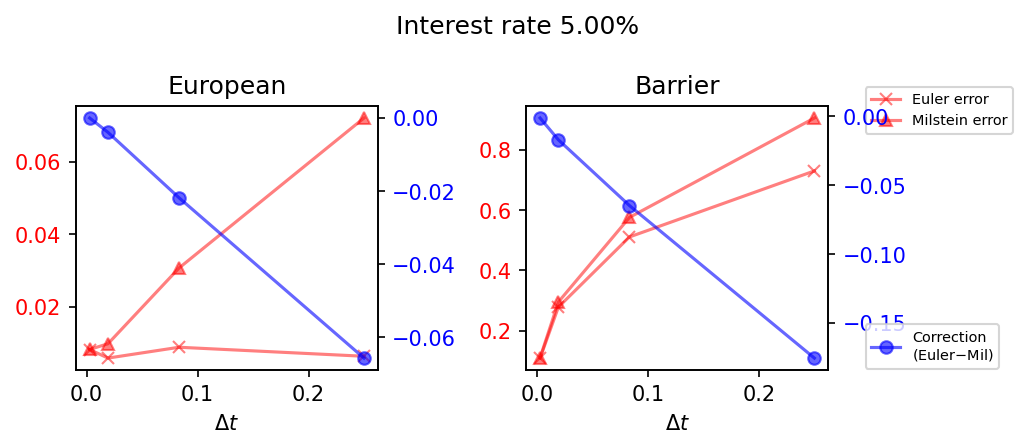

In [210]:
plotterBS(vary_interest=True)

### Vary volatility. Fix barrier= 80, interest rate= $1\%$

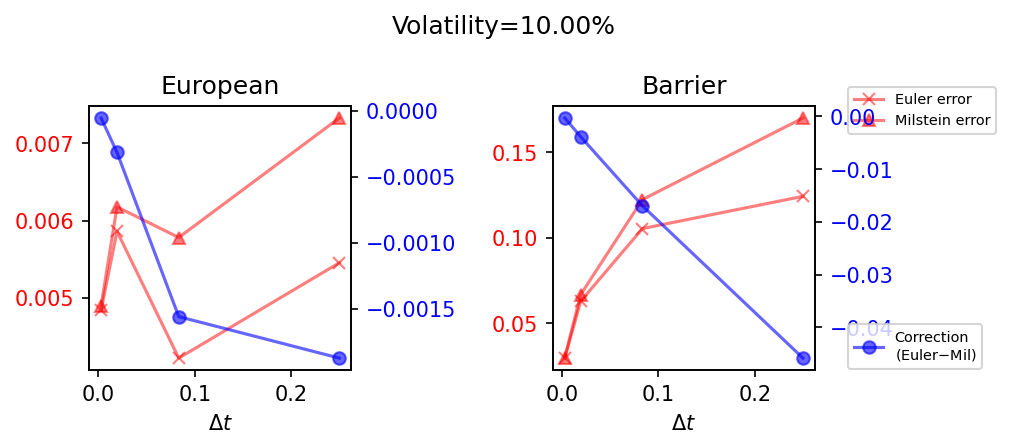

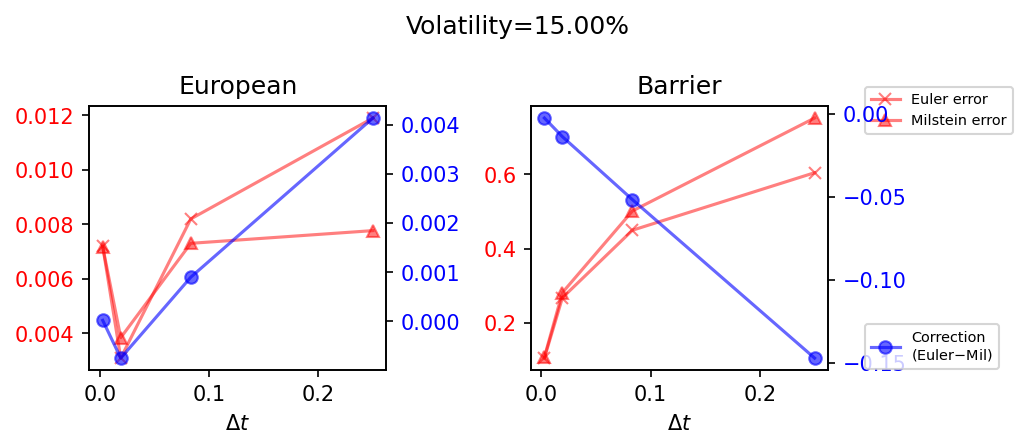

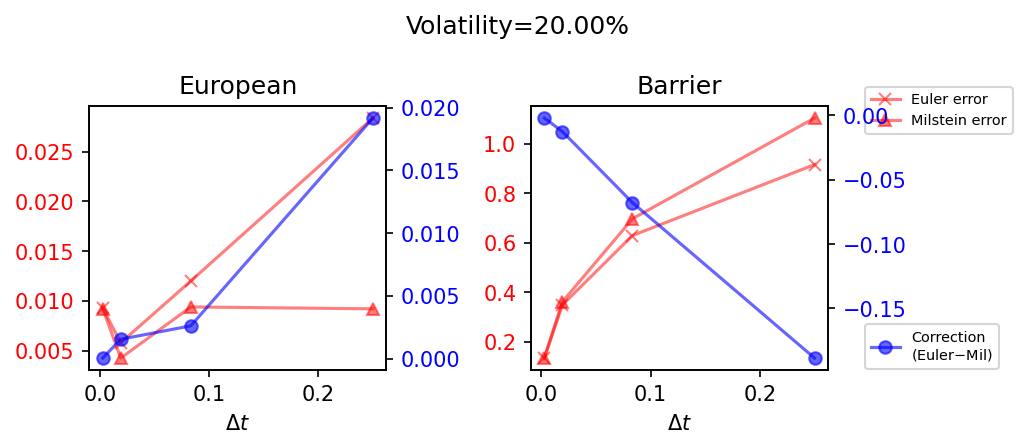

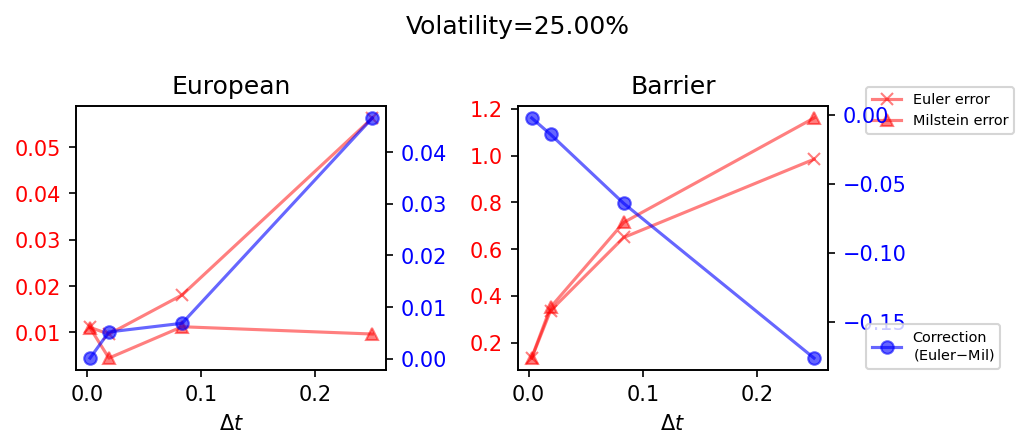

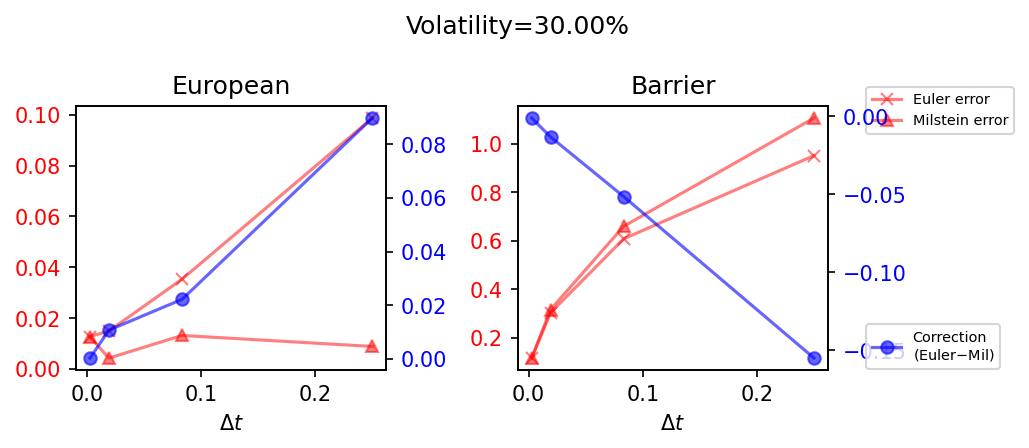

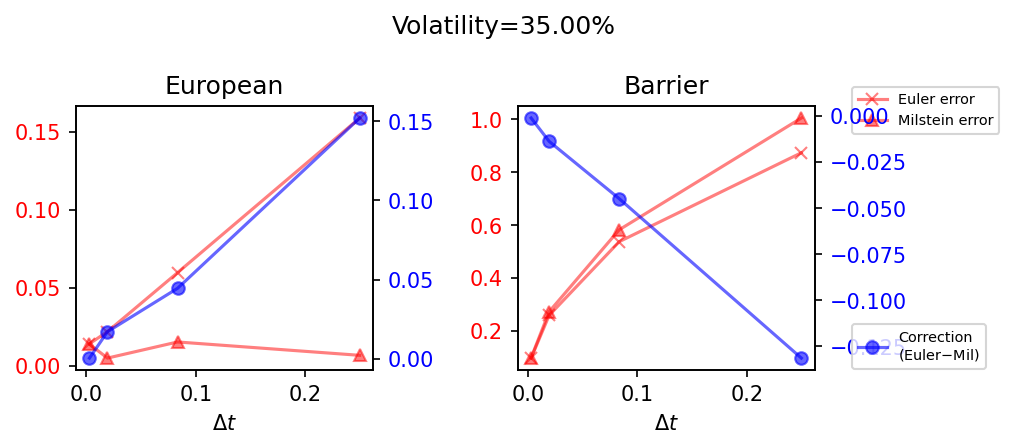

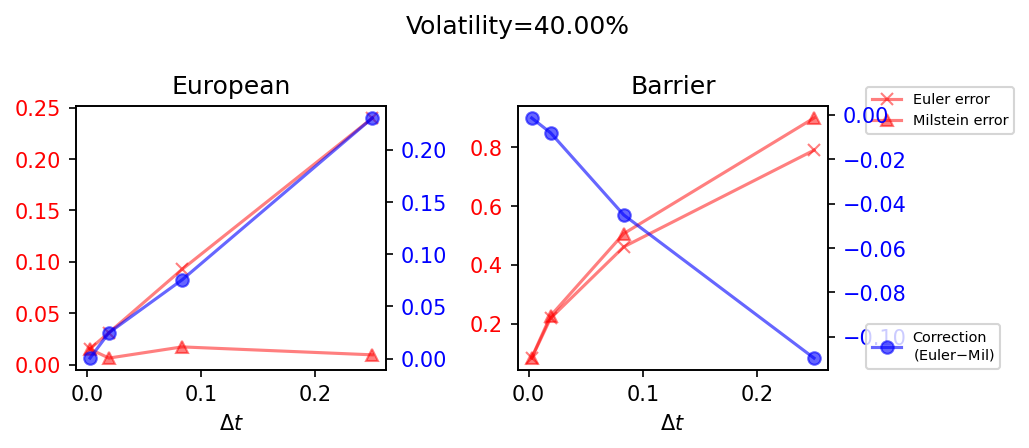

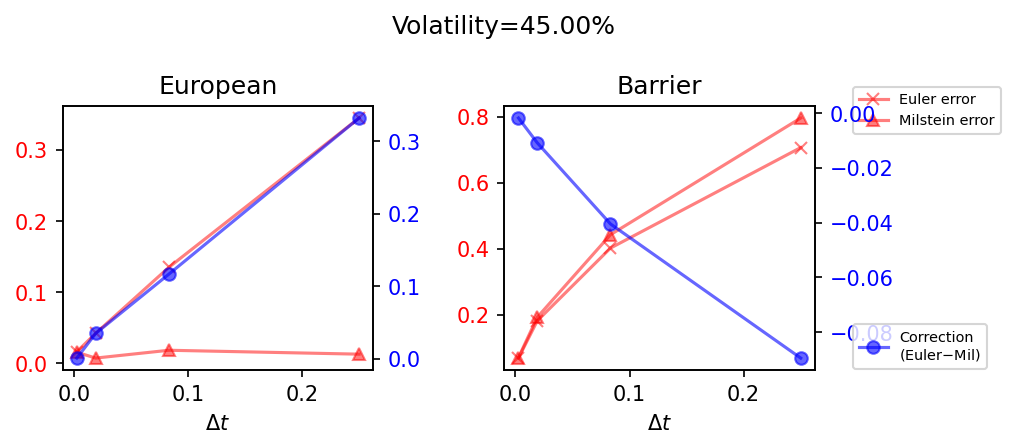

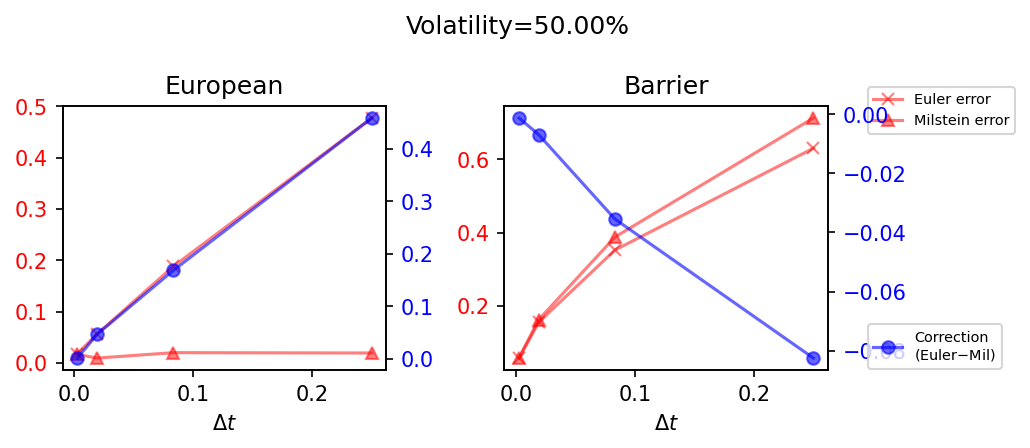

In [223]:
plotterBS(vary_interest=False,vary_vola=True)

### Vary barrier. Fix interest rate = $1\%$, volatility = $35\%$. 
**Note: - The European option plots (1st column) would be same as they dont depend on barrier.**

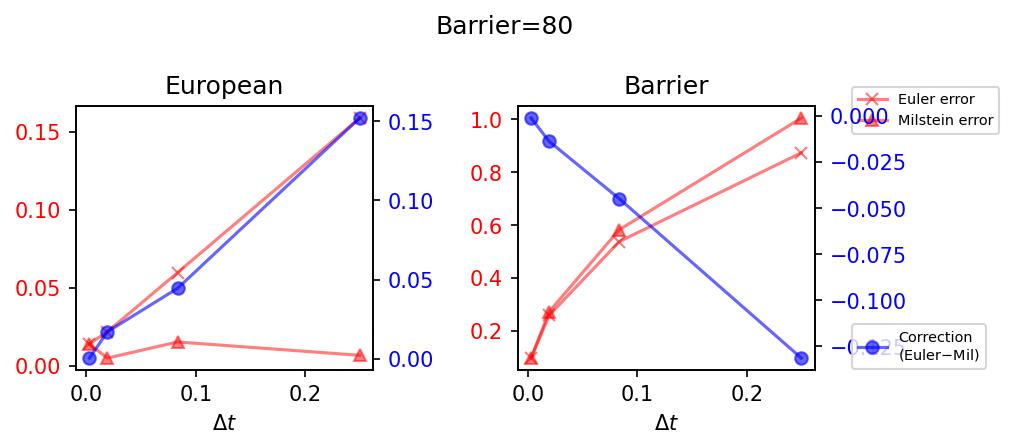

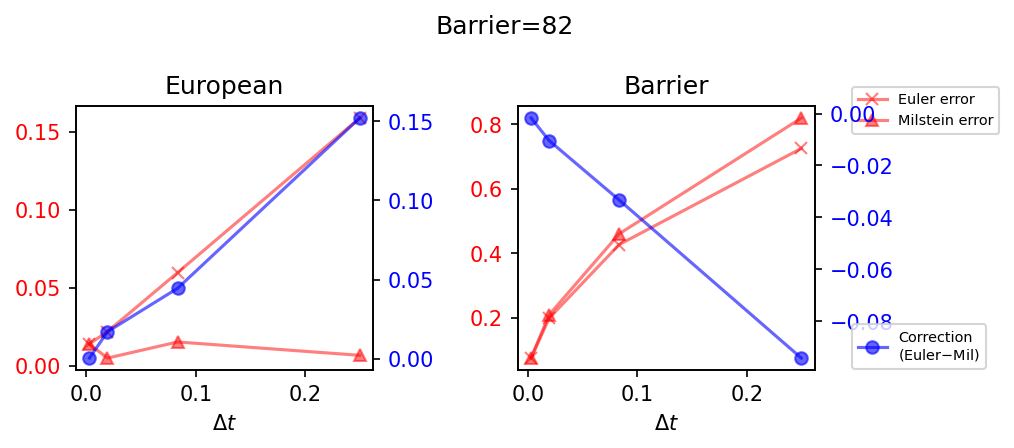

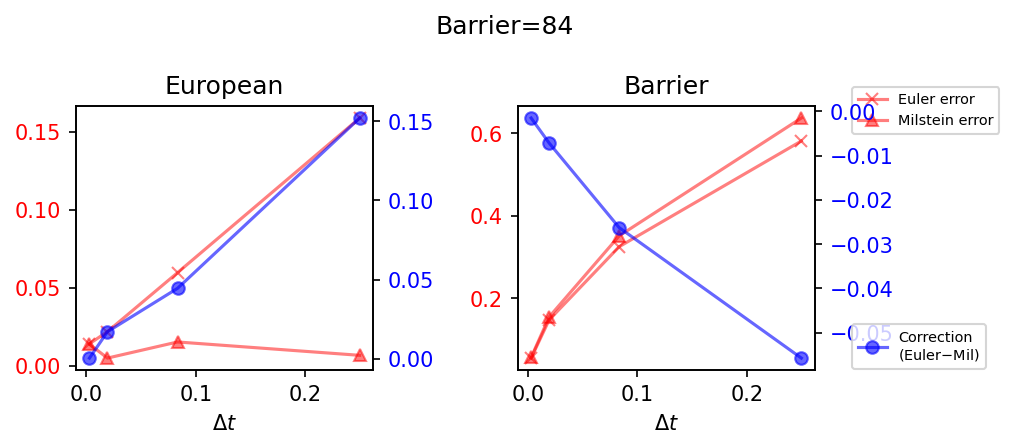

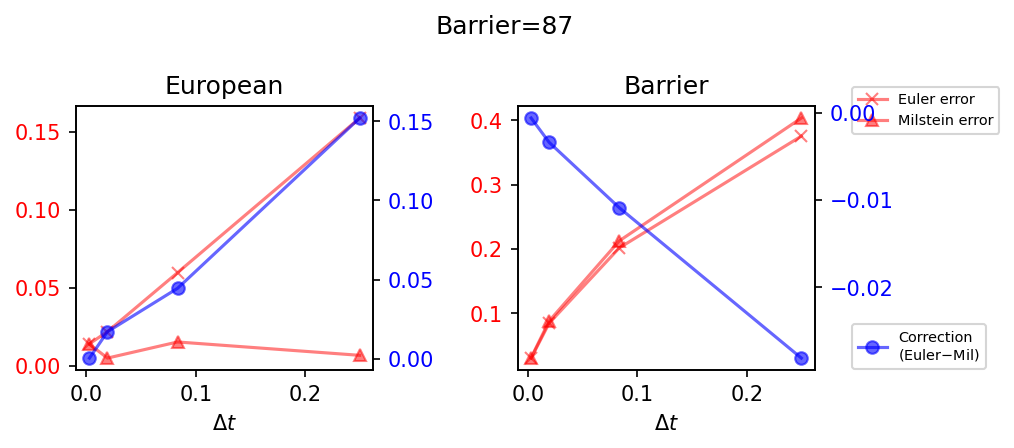

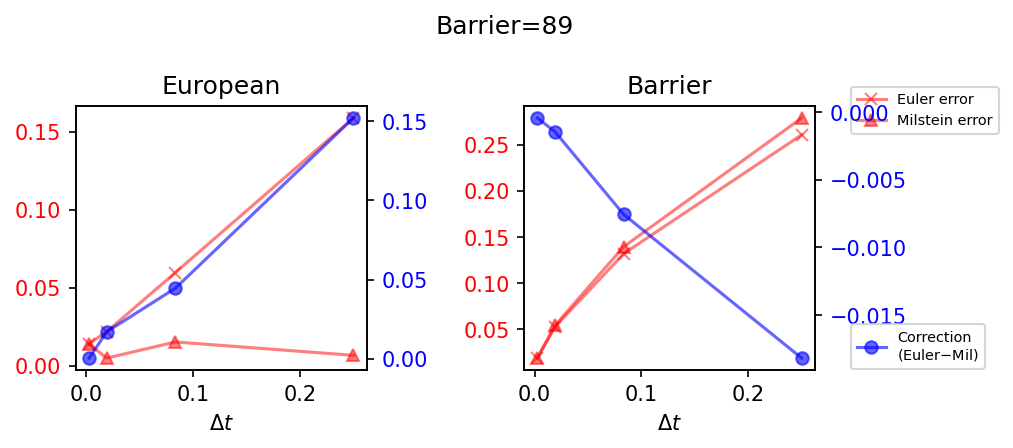

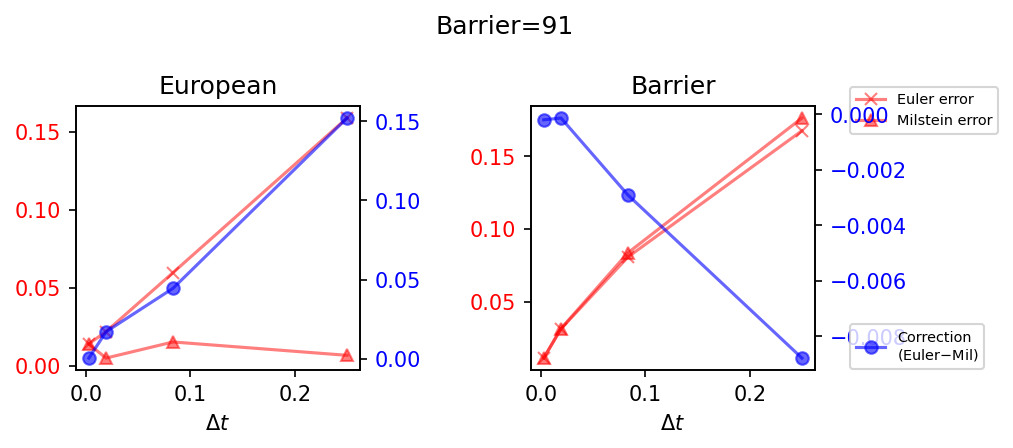

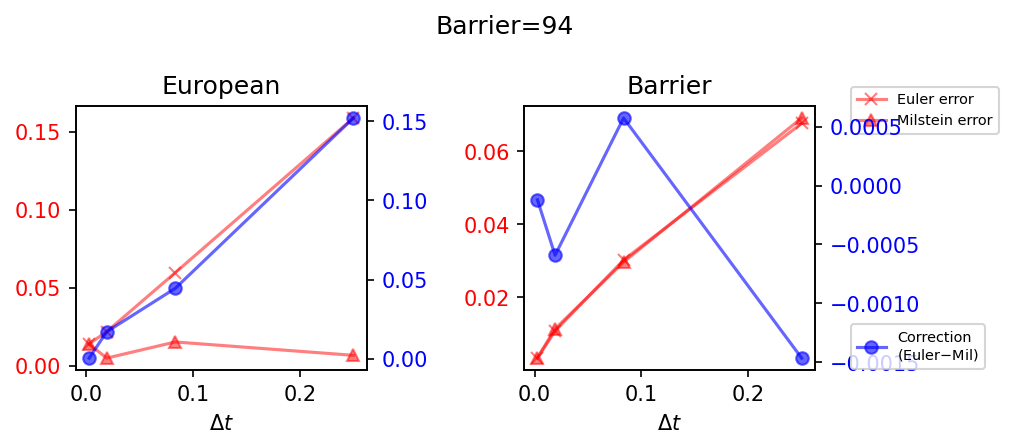

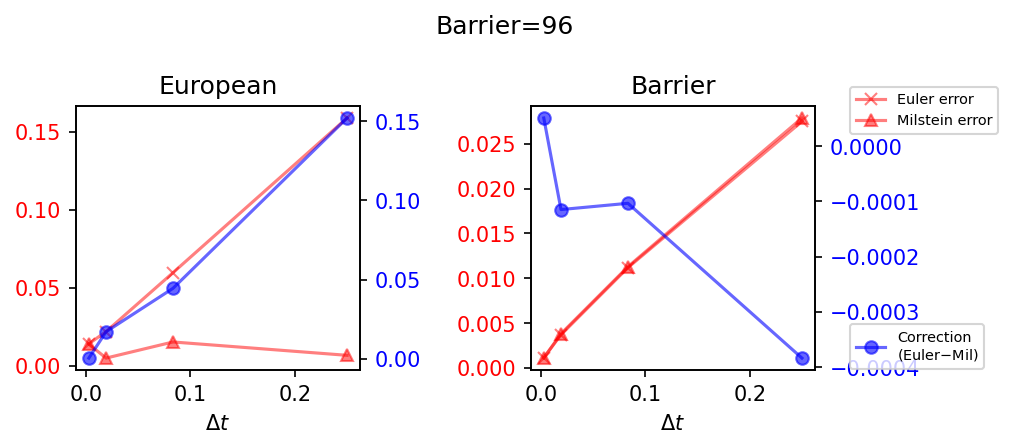

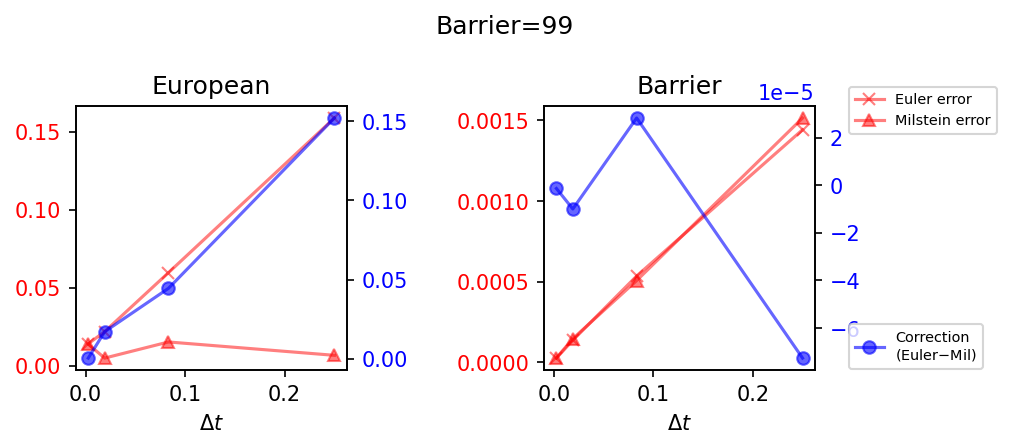

In [225]:
plotterBS(vary_interest=False, vary_vola=False, vary_bar=True)

# Heston Model

In [16]:
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    #assigning i=sqrt(-1)
    i = np.complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return value
    #return value[0][0]

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

# Determine coefficients for Put Prices 
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        #print('type of a:',type(a),' type of b:',type(b))
        #if (a < b) & (b < 0.0):
        if np.logical_and(a<b, b<0.0):
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)                  
    return H_k    

def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = np.complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    # Characteristic function for the Heston's model    
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    #S = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    #S[:,0]=S_0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Truncated boundary condition
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        #V[:,i+1] = np.maximum(V[:,i+1],0.0)
        V[:,i+1] = abs(V[:,i+1])
        
        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])
        #S[:,i+1] = S[:,i] + r*S[:,i]*dt + np.sqrt(V[:,i])*S[:,i]*(W2[:,i+1]-W2[:,i])
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

def GeneratePathsHestonMilstein(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    S[:,0]=S_0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Truncated boundary condition
        #v += kappa*(theta - v)*dt + sigma*np.sqrt(v*dt)*dZ_v[i] + 0.25*sigma**2*dt*(dZ_v[i]**2-1)
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i]) + 0.25*gamma**2*((W1[:,i+1]-W1[:,i])**2 - dt)
        #V[:,i+1] = np.maximum(V[:,i+1],0.0)
        V[:,i+1] = abs(V[:,i+1])
        #S += r*S*dt + np.sqrt(v_mil[j]*dt)*S*dZ_s[j] + 0.5*v_mil[j]*S*dt*(dZ_s[j]**2-1) 
        S[:,i+1] = S[:,i] + r*S[:,i]*dt + np.sqrt(V[:,i])*S[:,i]*(W2[:,i+1]-W2[:,i]) + 0.5*V[:,i]*S[:,i]*((W2[:,i+1]-W2[:,i])**2 - dt)
        time[i+1] = time[i] +dt
        
    #Compute exponent
    #S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths


def CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return  sample

def GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i]) #standardlized
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        
        # Exact samles for the variance process
        V[:,i+1] = CIR_Sample(NoOfPaths,kappa,gamma,vbar,0,dt,V[:,i])
        k0 = (r -rho/gamma*kappa*vbar)*dt
        k1 = (rho*kappa/gamma -0.5)*dt - rho/gamma
        k2 = rho / gamma
        X[:,i+1] = X[:,i] + k0 + k1*V[:,i] + k2 *V[:,i+1] + np.sqrt((1.0-rho**2)*V[:,i])*(W1[:,i+1]-W1[:,i])
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

def mainCalculationHES(steps, exactBarrierPrice, seed=1, maturity = 1, paths=20000):
    
    CP= OptionType.CALL #OptionType.PUT
    gamma = 1.4 
    kappa = 6 
    vbar  = 0.2 
    rho   = -0.7 
    v0    = 0.2 
    T     =  maturity
    S_0   =  100.0
    r     = 0.0015 #0.1
    K =   np.array([100.0])   #np.array([99.0])
    H = 80
    
    NoOfSteps =steps
    # Simulated paths
    NoOfPaths = paths
    
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    # Exact Put price
    exactPrice = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)
    #print('Exact european option price: ',exactPrice)
    #exactBarrierPrice = ExactHestonBarrier(CP, gamma, kappa, vbar, rho, v0, S_0, r, K, H,maturity)

    np.random.seed(seed)
    PathsEuler    = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    np.random.seed(seed)
    PathsMilstein = GeneratePathsHestonMilstein(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_Euler = PathsEuler["S"]
    S_Milstein = PathsMilstein["S"]
    priceEuler, seEuler = EUOptionPriceFromMCPaths(CP,S_Euler[:,-1],K,T,r)
    priceMilstein, seMil = EUOptionPriceFromMCPaths(CP,S_Milstein[:,-1],K,T,r)
    barrierpriceEuler, seBarEuler = BarrierOptionPriceFromMCPaths(CP,S_Euler,K,T,r,H)
    barrierpriceMilstein, seBarMil = BarrierOptionPriceFromMCPaths(CP,S_Milstein,K,T,r,H)
        
    return (abs(priceEuler-exactPrice), abs(priceMilstein-exactPrice), abs(barrierpriceEuler-exactBarrierPrice),
            abs(barrierpriceMilstein-exactBarrierPrice), seEuler, seMil, seBarEuler, seBarMil)

In [12]:
#Determine the exact price for Heston Barrier option using AES with large steps and no. of paths
def ExactHestonBarrier(CP, gamma, kappa, vbar, rho, v0, S_0, r, K, H,maturity):
    T = maturity
    NoOfPaths=100000
    NoOfSteps=2**10
    temp_price, temp_se = [], []
    print('********Running simulations for Exact Heston Barrier prices with AES*******')
    for i in tqdm(range(10)):
        pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_AES = pathsAES["S"]
        price, se = BarrierOptionPriceFromMCPaths(CP,S_AES,K,maturity,r,H)
        temp_price.append(price)
        temp_se.append(se)
        
    return np.mean(temp_price), np.mean(temp_se)

In [13]:
ExactBarrierHES = ExactHestonBarrier(CP=OptionType.CALL, gamma=1.4, kappa=6, vbar=0.2, rho=-0.7, 
                                       v0=0.2, S_0=100, r=0.0015, K=100, H=80,maturity=1)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

********Running simulations for Exact Heston Barrier prices with AES*******


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:07<00:00, 36.77s/it]


In [14]:
print('Almost exact price of Heston Down-and-Out call option is {:.2f} with std error {:.3f}'.
      format(ExactBarrierHES[0], ExactBarrierHES[1])) 

Almost exact price of Heston Down-and-Out call option is 13.60 with std error 0.082


In [17]:
path_grid = np.linspace(5e3,1e5,20,dtype=int)

seEuler, seMil, seBarEuler, seBarMil = [], [], [], [] 

for i in tqdm(path_grid):
    tempEuler, tempMil, tempBarEuler, tempBarMil = [], [], [], []
    for j in range(10):
        res = mainCalculationHES(steps=52, maturity=1,seed=np.random.randint(1,100),paths=i,
                                 exactBarrierPrice=ExactBarrierHES[0])
        tempEuler.append(res[4])
        tempMil.append(res[5])
        tempBarEuler.append(res[6])
        tempBarMil.append(res[7])
        
    seEuler.append(np.mean(tempEuler))
    seMil.append(np.mean(tempMil))
    seBarEuler.append(np.mean(tempBarEuler))
    seBarMil.append(np.mean(tempBarMil))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]<ipython-input-16-24d9c0e4f9ef>:76: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.complex(0.0,1.0)
<ipython-input-16-24d9c0e4f9ef>:16: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.complex(

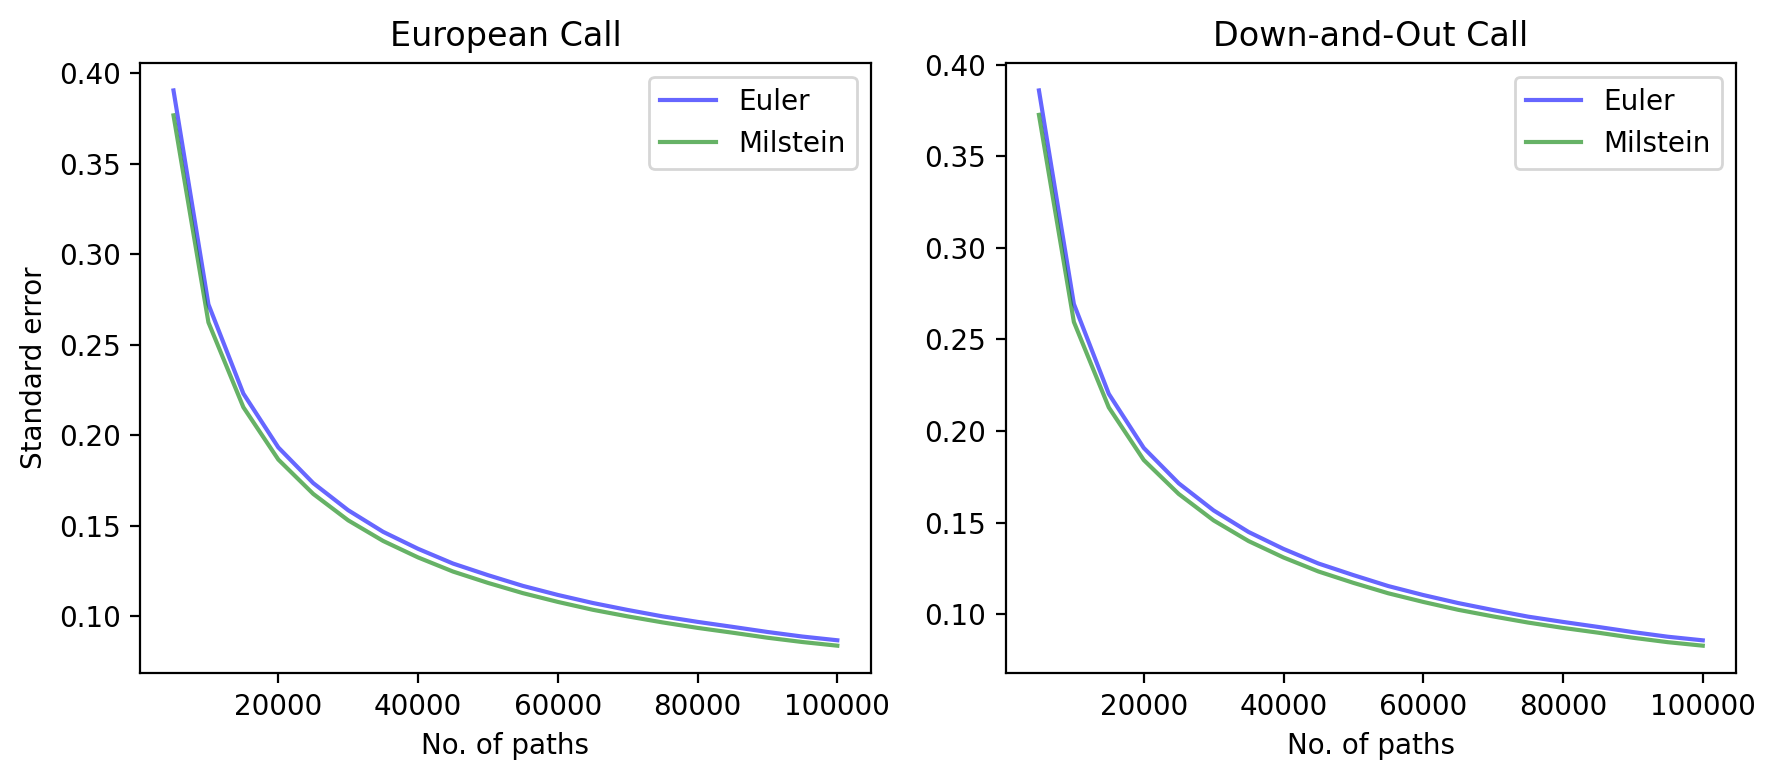

In [22]:
fig = plt.figure(figsize=(9,4),dpi=200)
plt.subplot(121)
plt.plot(path_grid, seEuler, 'b-',alpha=0.6, label="Euler")
plt.plot(path_grid, seMil, 'g-',alpha=0.6, label="Milstein")
plt.xlabel("No. of paths")
plt.ylabel('Standard error')
#plt.yscale('log')
plt.title('European Call')
plt.legend()

plt.subplot(122)
plt.plot(path_grid, seBarEuler, 'b-',alpha=0.6, label="Euler")
plt.plot(path_grid, seBarMil, 'g-',alpha=0.6, label="Milstein")
plt.xlabel("No. of paths")
#plt.ylabel('Standard error')
#plt.yscale('log')
plt.title('Down-and-Out Call')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
step_grid = [365,52,12,4]
err_eu, err_mil , errBar_eu, errBar_mil = [], [], [], [] 
for i in tqdm(step_grid):
  
    temp_eu, temp_mil, tempBar_eu, tempBar_mil = [], [], [], []
    for j in range(10):
        res = mainCalculationHES(steps=i, exactBarrierPrice=ExactBarrierHES[0], maturity=1,
                                 seed=np.random.randint(1,100),paths=100000)
        temp_eu.append(res[0])
        temp_mil.append(res[1])
        tempBar_eu.append(res[2])
        tempBar_mil.append(res[3])
        
    err_eu.append(np.mean(temp_eu))
    err_mil.append(np.mean(temp_mil)) 
    errBar_eu.append(np.mean(tempBar_eu))
    errBar_mil.append(np.mean(tempBar_mil))

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]<ipython-input-16-24d9c0e4f9ef>:76: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.complex(0.0,1.0)
<ipython-input-16-24d9c0e4f9ef>:16: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.complex(

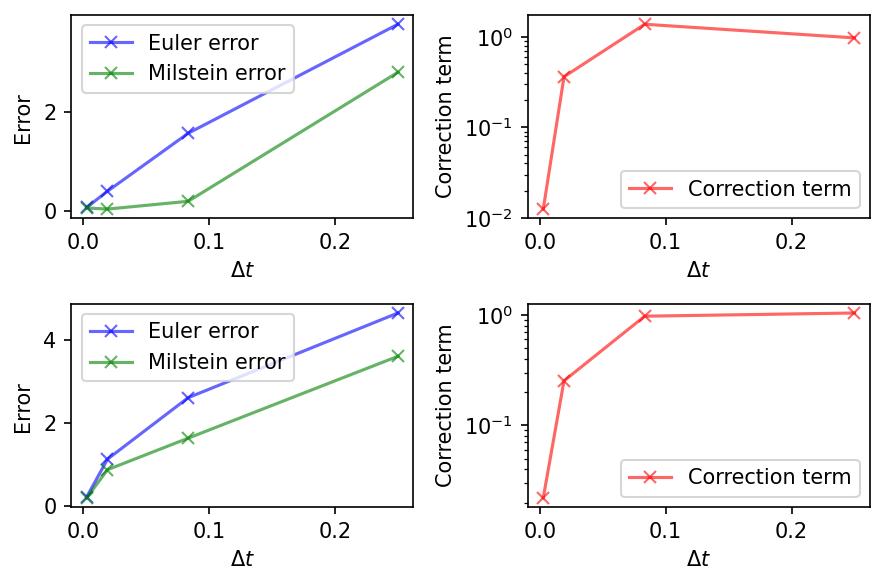

In [23]:
fig = plt.figure(dpi=150)
plt.subplot(221)
plt.plot(1/np.array(step_grid), err_eu, 'bx-',alpha=0.6,label="Euler error")
plt.plot(1/np.array(step_grid), err_mil, 'gx-',alpha=0.6,label="Milstein error")
plt.xlabel("$\Delta t$")
plt.ylabel('Error ')
plt.legend()

plt.subplot(222)
plt.plot(1/np.array(step_grid), np.array(err_eu) - np.array(err_mil), 'rx-',alpha=0.6,label="Correction term")
plt.xlabel("$\Delta t$")
plt.ylabel('Correction term')
plt.yscale('log')
plt.legend()


plt.subplot(223)
plt.plot(1/np.array(step_grid), errBar_eu, 'bx-',alpha=0.6,label="Euler error")
plt.plot(1/np.array(step_grid), errBar_mil, 'gx-',alpha=0.6,label="Milstein error")
plt.xlabel("$\Delta t$")
plt.ylabel('Error ')
plt.legend()

plt.subplot(224)
plt.plot(1/np.array(step_grid), np.array(errBar_eu) - np.array(errBar_mil), 'rx-',alpha=0.6,label="Correction term")
plt.xlabel("$\Delta t$")
plt.ylabel('Correction term')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()